# Loop flow example

This is a test case with particles released in a simple looping flow field
The streamfunction is given by 

$s=sin(\pi*x)*sin(\pi*y)$

The domain is $x \in [0,1], y \in [0,1]$

In [1]:
# Load required libraries
using Pkg
Pkg.activate("..")
using Particles
using Plots
using Random

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

  Activating environment at `~/src_nobackup/Particles.jl/Project.toml`


In [2]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults
# settings for this experiment
n = 30 # number of particles
d["nparticles"] = n
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = 0.2 .+ 0.02 * randn(randpool, n, 1) # particles are spawned roughly at (0.2,0.2)
p[2, :] = 0.2 .+ 0.02 * randn(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 0.01     #time-step
d["tstart"] = 0.0 
d["tend"] = 2.5
# write to netcdf
d["write_maps_times"] = collect(0.0:0.1:2.5)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:0.5:2.5)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(600,400)

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(0.0:0.1:2.5)

d #show configuration

Dict{String, Any} with 24 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [0.213582 0.216568 … 0.209474 0.206005; 0.228461 0.…
  "nparticles"           => 30
  "plot_maps_times"      => [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
  "dt"                   => 0.01
  "tend"                 => 2.5
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_loop.nc"
  "variables"            => ["x", "y", "z", "age"]
  "keep_particle_times"  => [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "plot_maps_func"       => plot_maps_xy
  "coordinates"          => "projected"
  "write_maps_times"     => [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …
  "plot_maps_size"       => (600, 400)
  ⋮                      => ⋮

In [3]:
# Define the flow field

# forcing currents stream (used only for plotting here) , u and v
function stream(x, y, z, t)
    sin(pi * x) * sin(pi * y)
end
# flow in x direction (for now has to be called u)
function u(x, y, z, t)
   # u=-s_y
    -sin(pi * x) * cos(pi * y)
end

# flow in y direction (for now has to be called v)
function v(x, y, z, t)
   # v=s_x
    cos(pi * x) * sin(pi * y)
end

nothing

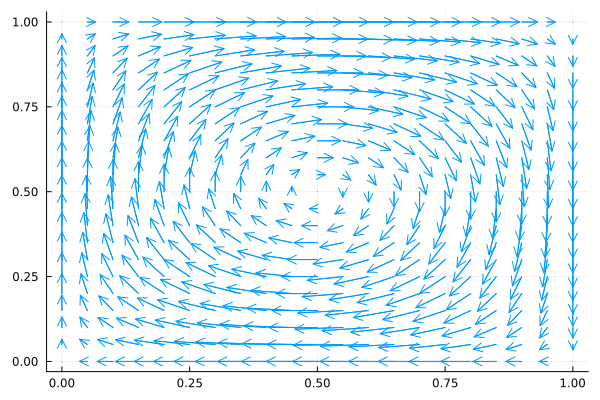

In [4]:
#plot flow field

#grid for plotting
mygrid=0:0.05:1.0
n=length(mygrid)
xs=kron(mygrid,ones(n))
ys=kron(ones(n),mygrid)

Plots.default(:size, d["plot_maps_size"])
scale=0.1
quiver(xs,ys,quiver=(scale*u.(xs,ys,0.0,0.0),scale*v.(xs,ys,0.0,0.0)))

In [5]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

f! (generic function with 1 method)

In [6]:
# use streamfunction as background for plotting

function plot_background(d)
    # streamfunction for plot
     x1 = 0.0:0.01:1.0
     y1 = 0.0:0.01:1.0
     flow = zeros(length(x1), length(y1))
     for i = 1:length(x1)
         for j = 1:length(y1)
             flow[i,j] = stream(x1[i], y1[j], 0.0, 0.0)
         end
     end
     f = contour(x1, y1, flow', legend=false)
     return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [7]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = 

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
interrupt simulation for output at t = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]


Simulation from time 0.0 s to 2.5 s since 2000-01-01T00:00:00 since 2000-01-01T00:00:00
t=0.0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%


t=0.0 -> 0.1  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 4.0%


t=0.09999999999999999 -> 0.2  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 8.0%
t=0.20000000000000004 -> 0.3  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 12.0%
t=0.3000000000000001 -> 0.4  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 16.0%
t=0.4000000000000002 -> 0.5  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 20.0%
t=0.5000000000000002 -> 0.6  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 24.0%
t=0.6000000000000003 -> 0.7  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 28.0%
t=0.7000000000000004 -> 0.8  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 32.0%
t=0.8000000000000005 -> 0.9  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 36.0%
t=0.9000000000000006 -> 1.0  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 40.0%
t=1.0000000000000007 -> 1.1  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 44.0%
t=1.1000000000000008 -> 1.2  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 48.0%
t=1.2000000000000008 -> 1.3  : 2000-01-01T00:00:01 -> 2000-01-01T00:00:01 : 52.0%
t=1.30000000000

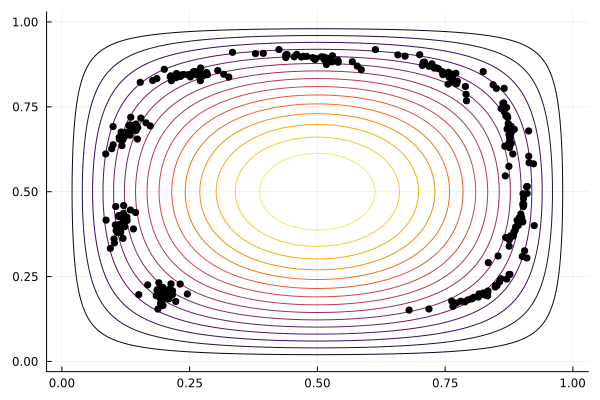

In [8]:
t_all=d["keep_particle_times"]
fig2 = d["plot_maps_background"](d)
# scatter!(fig1,p[1,:],p[2,:],legend=false)
for i in 1:3:length(t_all)
    p_temp=d["all_particles"]
    d["plot_maps_func"](fig2, d, p_temp[i])
end
display(fig2)